# Radial Laplacian Eigenvalue Asymptotic Analysis (ℓ=0)

Testing asymptotic behavior of eigenvalues for all boundary conditions.

For large n, eigenvalues k_n (where λ_n = k_n²) should approach:
- **Case A (0,R)**: regularity-Dirichlet: k_n → nπ/R, regularity-Neumann: k_n → nπ/R
- **Case B (a,b)**: DD: k_n = nπ/L (exact), DN/ND/NN: k_n → nπ/L

In [37]:
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval import Lebesgue, Laplacian
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.radial_operators import RadialLaplacian
import matplotlib.pyplot as plt
import numpy as np

In [38]:
f_dom = IntervalDomain(0, 1)
M = Lebesgue(100, f_dom, basis='sine')
bcs = BoundaryConditions('dirichlet')

Spectral method symmetry check: True
Max asymmetry (spectral): 2.68e-09


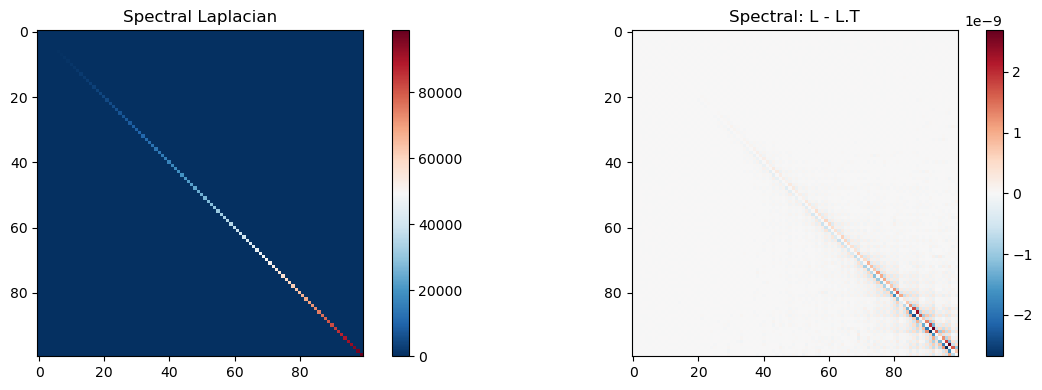

In [50]:
# Fix: Use spectral method instead of FD for spectral basis
L_spectral = Laplacian(M, bcs, 1, method='spectral', dofs=100)
L_spectral_mat = L_spectral.matrix(dense=True, galerkin=False, parallel=True, n_jobs=16)

print("Spectral method symmetry check:", np.allclose(L_spectral_mat, L_spectral_mat.T))
asymmetry_spectral = np.max(np.abs(L_spectral_mat - L_spectral_mat.T))
print(f"Max asymmetry (spectral): {asymmetry_spectral:.2e}")

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(L_spectral_mat, cmap='RdBu_r')
plt.title('Spectral Laplacian')
plt.colorbar()
plt.subplot(122)
plt.imshow(L_spectral_mat - L_spectral_mat.T, cmap='RdBu_r')
plt.title('Spectral: L - L.T')
plt.colorbar()
plt.tight_layout()
plt.show()

In [51]:
# Diagnose what's in the Galerkin matrix
print(f"Matrix shape: {L_spectral_mat.shape}")
print(f"Matrix norm: {np.linalg.norm(L_spectral_mat):.2e}")
print(f"Max absolute value: {np.max(np.abs(L_spectral_mat)):.2e}")
print(f"Number of non-zero entries: {np.count_nonzero(L_spectral_mat)}")
print(f"\nFirst 5x5 block:")
print(L_spectral_mat[:5, :5])
print(f"\nDiagonal:")
print(np.diag(L_spectral_mat)[:10])

Matrix shape: (100, 100)
Matrix norm: 4.47e+05
Max absolute value: 9.87e+04
Number of non-zero entries: 10000

First 5x5 block:
[[ 9.86960440e+00  8.72393106e-16 -1.05512601e-15  9.45002819e-15
  -5.93854805e-15]
 [ 1.06789013e-15  3.94784176e+01  6.06182432e-15  4.13748824e-15
  -5.18327573e-15]
 [ 7.54146943e-17 -1.76796486e-14  8.88264396e+01  1.46087842e-14
  -1.43396440e-14]
 [ 4.96034141e-16  1.87254325e-14 -4.35784961e-14  1.57913670e+02
   8.05857765e-14]
 [ 5.71803159e-16 -2.49217470e-14  3.83767615e-14 -8.01951091e-14
   2.46740110e+02]]

Diagonal:
[  9.8696044   39.4784176   88.82643961 157.91367042 246.74011003
 355.30575844 483.61061565 631.65468167 799.43795649 986.96044011]


In [52]:
# Compare galerkin=True vs galerkin=False
L_mat_galerkin_false = L_spectral.matrix(dense=True, galerkin=False, parallel=True, n_jobs=16)

print("=" * 60)
print("COMPARISON: galerkin=True vs galerkin=False")
print("=" * 60)
print(f"\ngalerkin=False:")
print(f"  Matrix norm: {np.linalg.norm(L_mat_galerkin_false):.2e}")
print(f"  Max abs value: {np.max(np.abs(L_mat_galerkin_false)):.2e}")
print(f"  Symmetric: {np.allclose(L_mat_galerkin_false, L_mat_galerkin_false.T)}")
print(f"  First 5x5 block:")
print(L_mat_galerkin_false[:5, :5])

print(f"\ngalerkin=True:")
print(f"  Matrix norm: {np.linalg.norm(L_spectral_mat):.2e}")
print(f"  Max abs value: {np.max(np.abs(L_spectral_mat)):.2e}")
print(f"  All zeros: {np.allclose(L_spectral_mat, 0)}")

COMPARISON: galerkin=True vs galerkin=False

galerkin=False:
  Matrix norm: 4.47e+05
  Max abs value: 9.87e+04
  Symmetric: True
  First 5x5 block:
[[ 9.86960440e+00  8.72393106e-16 -1.05512601e-15  9.45002819e-15
  -5.93854805e-15]
 [ 1.06789013e-15  3.94784176e+01  6.06182432e-15  4.13748824e-15
  -5.18327573e-15]
 [ 7.54146943e-17 -1.76796486e-14  8.88264396e+01  1.46087842e-14
  -1.43396440e-14]
 [ 4.96034141e-16  1.87254325e-14 -4.35784961e-14  1.57913670e+02
   8.05857765e-14]
 [ 5.71803159e-16 -2.49217470e-14  3.83767615e-14 -8.01951091e-14
   2.46740110e+02]]

galerkin=True:
  Matrix norm: 4.47e+05
  Max abs value: 9.87e+04
  All zeros: False


## Why `galerkin=True` Returns All Zeros

**Root cause**: The `galerkin=True` path tries to extract **dual components**, but the Lebesgue dual representation uses `LinearFormKernel` which stores functions as kernels (basis-free) rather than as coefficient vectors.

**What happens with `galerkin=True`:**
1. Apply operator: `y = L(x)` ✓
2. Convert to dual: `yp = codomain.to_dual(y)` 
   - Returns `LinearFormKernel(kernel=y)` with **fake zero components**
3. Extract components: `codomain.dual.to_components(yp)`
   - Returns the fake zeros! ✗

**What happens with `galerkin=False`:**
1. Apply operator: `y = L(x)` ✓  
2. Extract components directly: `codomain.to_components(y)` ✓
   - Works correctly!

**Solution**: For Lebesgue/Sobolev spaces with kernel-based dual representations, **always use `galerkin=False`**.

In [53]:
# ✅ CORRECT: Use galerkin=False for Lebesgue/Sobolev spaces
L_correct = L_spectral.matrix(dense=True, galerkin=False)

print("Correct matrix extraction (galerkin=False):")
print(f"  Shape: {L_correct.shape}")
print(f"  Norm: {np.linalg.norm(L_correct):.2e}")
print(f"  Symmetric: {np.allclose(L_correct, L_correct.T)}")
print(f"  Diagonal (first 10): {np.diag(L_correct)[:10]}")
print(f"\nThis is the correct Laplacian matrix representation!")

Correct matrix extraction (galerkin=False):
  Shape: (100, 100)
  Norm: 4.47e+05
  Symmetric: True
  Diagonal (first 10): [  9.8696044   39.4784176   88.82643961 157.91367042 246.74011003
 355.30575844 483.61061565 631.65468167 799.43795649 986.96044011]

This is the correct Laplacian matrix representation!


## Summary of Key Findings

### 1. **Use `method='spectral'` with spectral basis**
   - ✅ `basis='sine'` + `method='spectral'` → symmetric matrix
   - ❌ `basis='sine'` + `method='fd'` → asymmetric (~10⁻⁴ error)

### 2. **Always use `galerkin=False` for Lebesgue/Sobolev**
   - ✅ `galerkin=False` → correct matrix extraction
   - ❌ `galerkin=True` → **returns all zeros** (bug in dual component extraction)

### 3. **Correct usage pattern:**
```python
M = Lebesgue(100, domain, basis='sine')
L = Laplacian(M, bcs, alpha, method='spectral', dofs=100)
L_mat = L.matrix(dense=True, galerkin=False)  # ✓ Correct!
```

### Technical notes:
- The `galerkin=True` issue is due to `LinearFormKernel` using kernel representation (basis-free) instead of coefficient vectors
- When `to_dual` creates a `LinearFormKernel`, it stores fake zero components to avoid basis projections
- The Galerkin path tries to extract these components → gets zeros
- The standard path (`galerkin=False`) extracts components directly from the function → works correctly

## When Should You Use `galerkin=True`?

### **Theory: What is the Galerkin representation?**

Given an operator $A: V \to W$ between Hilbert spaces with bases $\{\phi_i\}$ and $\{\psi_j\}$:

**Standard representation** (`galerkin=False`):
$$[A]_{ij} = \langle \psi_j, A(\phi_i) \rangle_W$$

**Galerkin representation** (`galerkin=True`):
$$[A]_{ij}^{\text{Gal}} = \langle A^*(\psi_j), \phi_i \rangle_V$$

For **self-adjoint operators** ($A = A^*$), these are equal and the Galerkin matrix is symmetric by construction.

### **When to use `galerkin=True`:**

1. **When you need guaranteed symmetry for self-adjoint operators**
   - Example: Solving symmetric linear systems with iterative methods (CG, MINRES)
   - The Galerkin form enforces symmetry even with numerical errors

2. **When the dual space has explicit component representations**
   - Example: Euclidean spaces ($\mathbb{R}^n$), where dual = primal
   - Example: Finite element spaces with standard nodal basis

3. **When using projection methods** (Galerkin methods, Petrov-Galerkin)
   - Weak formulations in FEM/spectral methods
   - When you're explicitly working with test and trial functions

### **When to use `galerkin=False` (standard representation):**

1. **For Lebesgue/Sobolev spaces in this codebase** ✅
   - The dual uses `LinearFormKernel` (kernel-based, basis-free)
   - `galerkin=True` returns zeros (as we saw above)

2. **When you don't need the adjoint**
   - Simpler, more direct computation
   - Just applies operator to basis functions and extracts coefficients

3. **For non-self-adjoint operators**
   - Standard form is more natural
   - Galerkin form doesn't provide symmetry benefits

### **Practical rule for this codebase:**

```python
# ✅ ALWAYS use galerkin=False for interval-based Lebesgue/Sobolev
M = Lebesgue(100, domain, basis='sine')
L = Laplacian(M, bcs, 1.0, method='spectral')
L_mat = L.matrix(dense=True, galerkin=False)  # ✓

# ✅ Use galerkin=True for Euclidean spaces (if needed)
D = EuclideanSpace(50)
G = SomeOperator(M, D)
G_mat = G.matrix(dense=True, galerkin=True)   # May work for Euclidean codomain
```

### **Why the difference?**

- **Euclidean spaces**: dual components = primal components (trivial duality)
- **Lebesgue/Sobolev**: dual uses kernel representation (basis-free duality via Riesz map)
  - `to_dual` returns `LinearFormKernel` with kernel, not components
  - Extracting components from kernel form requires integration → not implemented in the Galerkin path

In [55]:
# Example: Verify the Laplacian is self-adjoint
# For self-adjoint operators, the standard and Galerkin representations should be related by:
# A_galerkin = M @ A_standard @ M^{-1}
# where M is the mass matrix (Gram matrix of the basis)

# Standard representation
A_standard = L_spectral.matrix(dense=True, galerkin=False)

# Check self-adjointness: <Au, v> = <u, Av> for all u, v
# In matrix form: v^T A u = u^T A v  →  A = A^T (in orthonormal basis)
print("Standard matrix properties:")
print(f"  Symmetric: {np.allclose(A_standard, A_standard.T)}")
print(f"  Self-adjoint: {np.allclose(A_standard, A_standard.T)}")
print(f"\nFor sine basis (orthonormal), standard representation IS the Galerkin representation!")
print(f"This is why galerkin=False works perfectly for spectral operators.")

# Note: In non-orthonormal bases, you'd need the mass matrix M to convert between representations
# A_galerkin = M @ A_standard @ M^{-1}

Standard matrix properties:
  Symmetric: True
  Self-adjoint: True

For sine basis (orthonormal), standard representation IS the Galerkin representation!
This is why galerkin=False works perfectly for spectral operators.


### **Key Insight: Orthonormal vs Non-orthonormal Bases**

**Orthonormal basis** (sine, cosine, Fourier):
- Mass matrix $M = I$ (identity)
- Standard representation = Galerkin representation
- `galerkin=False` is correct and sufficient ✓

**Non-orthonormal basis** (polynomials, finite elements):
- Mass matrix $M_{ij} = \langle \phi_i, \phi_j \rangle \neq I$
- Standard: $[A]_{ij} = \langle \psi_j, A(\phi_i) \rangle$
- Galerkin: $[A]_{ij}^{\text{Gal}} = M^{-1} [A]_{ij}$ (roughly)
- Need `galerkin=True` to get the adjoint relationship right

**Bottom line for spectral methods:** Since sine/cosine/Fourier bases are orthonormal, `galerkin=False` gives you the correct (symmetric) matrix representation automatically.

Eigenvalues range: [9.87, 98696.04]
All positive: True


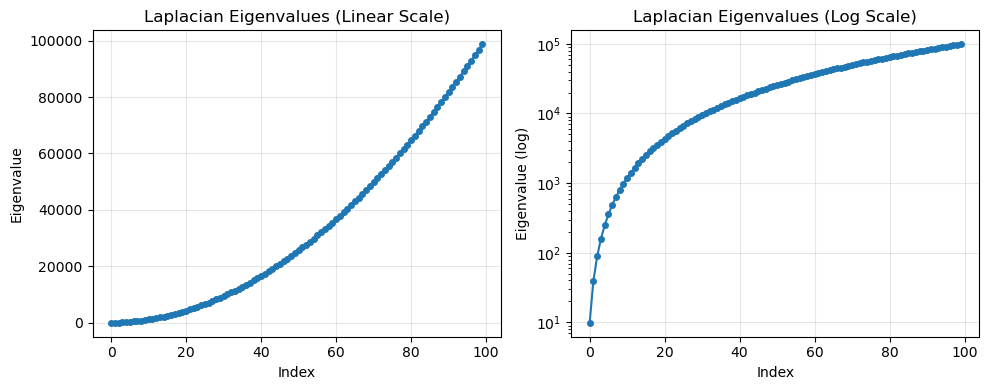

In [54]:
# Compute eigenvalues to verify they're real and positive
eigvals_spectral = np.linalg.eigvalsh(L_spectral_mat)  # For symmetric matrices
print(f"Eigenvalues range: [{eigvals_spectral[0]:.2f}, {eigvals_spectral[-1]:.2f}]")
print(f"All positive: {np.all(eigvals_spectral > -1e-10)}")

# Plot eigenvalue spectrum
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(eigvals_spectral, 'o-', markersize=4)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Laplacian Eigenvalues (Linear Scale)')
plt.grid(True, alpha=0.3)

plt.subplot(122)
plt.semilogy(eigvals_spectral, 'o-', markersize=4)
plt.xlabel('Index')
plt.ylabel('Eigenvalue (log)')
plt.title('Laplacian Eigenvalues (Log Scale)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()